In [52]:
import pandas as pd
import numpy as np
import json
from harvest.location.pipeline_model import PipelineModel
from sklearn.cross_validation import KFold

pipeline = json.load(open('/home/rloliveirajr/idxp/production/harvest/1/4/configuration.json'))[0]
model = PipelineModel.create(pipeline['localization_params'])
data = pd.read_csv("/home/rloliveirajr/idxp/production/harvest/1/4/training_set_2015-08-25.csv")
X, y = data.drop('area_id', 1).values, data.area_id.values

from sklearn.datasets import load_diabetes as l_data
data = l_data()
y = data.target
X = data.data
X.shape

(442, 10)

In [53]:
kfolds = KFold(y.shape[0], n_folds=5, random_state=1, shuffle=True)
folds = []
for train, test in kfolds:
    folds.append(test)

import itertools
folds_permutation = list(itertools.permutations(range(len(folds))))

In [54]:
fold_experiment = set([])
for f in folds_permutation:
    unlabeled = "_".join([str(i) for i in sorted(f[2:-3])])
    tra = f[0]
    val = f[1]
    unl = "_".join([str(i) for i in sorted(f[-3:-1])])
    tes = f[-1]
    fold_experiment.add((tra, val, unlabeled, unl, tes))
len(fold_experiment)

60

In [55]:
from IPython.display import display
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

def uncertanty_simple(probs):
    return 1 - np.max(probs, axis=1)

def diff_uncertanty(probs):
    min_diff = 1000
    for i, p_i in enumerate(probs):
        for j, p_j in enumerate(probs):
            if i == j:
                continue
            diff = p_i - p_j
            if diff < min_diff:
                min_diff = diff
    return min_diff

def euclidean_dist(x_1, x_2):
    return sum([(i-j)**2 for i, j in zip(x_1, x_2)]) / len(x_1)
    
def get_instances_id(folds, idx):
    f = []
    for i in idx:
        f += list(folds[i])
    return f


def active_learn_model(model, X, y, train, validation, unlabeled):
    model.fit(X[train], y[train])
    pred = model.predict(X[validation])
    baseline = precision_score(y[validation], pred, average="macro")
    probas = model.predict_proba(X[unlabeled])
    unc = uncertanty_simple(probas)
    diff_unc = [diff_uncertanty(p) for p in probas]
    euc_dist = []
    rank = []
    
    for u in unlabeled:
        dist = [euclidean_dist(X[u], x_i) for x_i in X[train]]
        euc_dist.append(np.mean(dist)/np.std(dist))
        train_u = list(train) + [u]
        X_u = X[train_u]
        y_u = y[train_u]
        model.fit(X_u, y_u)
        pred = model.predict(X[validation])
        acc = precision_score(y[validation], pred, average="macro")
        rank.append(baseline - acc)
    
    
    return list(zip(unc, diff_unc, euc_dist, rank))

data_model = []
for fff in fold_experiment:
    fff = list(fff)
    i_train = folds[fff[0]]
    i_val = folds[fff[1]]
    i_tes = folds[fff[3]]
    i_unl = get_instances_id(folds, [int(i) for i in fff[2].split("_")])
    data_model += active_learn_model(model, X, y, i_train, i_val)
    break
active_data = pd.DataFrame(data_model, 
                           columns=["uncertanty_simple", "diff_uncertanty", "euc_dist", "rank"])
active_data

/home/rloliveirajr/.pyenv/versions/brain/lib/python3.4/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rloliveirajr/.pyenv/versions/brain/lib/python3.4/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rloliveirajr/.pyenv/versions/brain/lib/python3.4/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rloliveirajr/.pyenv/versions/brain/lib/python3.4/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

,uncertanty_simple,diff_uncertanty,euc_dist,rank
0,0.742,-0.258,1.848600,0.000000
1,0.886,-0.114,1.581137,0.000000
2,0.878,-0.122,1.321251,0.000000
3,0.838,-0.162,1.544085,0.000000
4,0.862,-0.138,1.460806,0.000000
5,0.866,-0.134,1.811957,0.000000
6,0.828,-0.172,1.686505,0.000000
7,0.942,-0.058,1.862183,0.000000
8,0.896,-0.104,1.740641,0.000000
9,0.924,-0.076,1.604988,0.000000


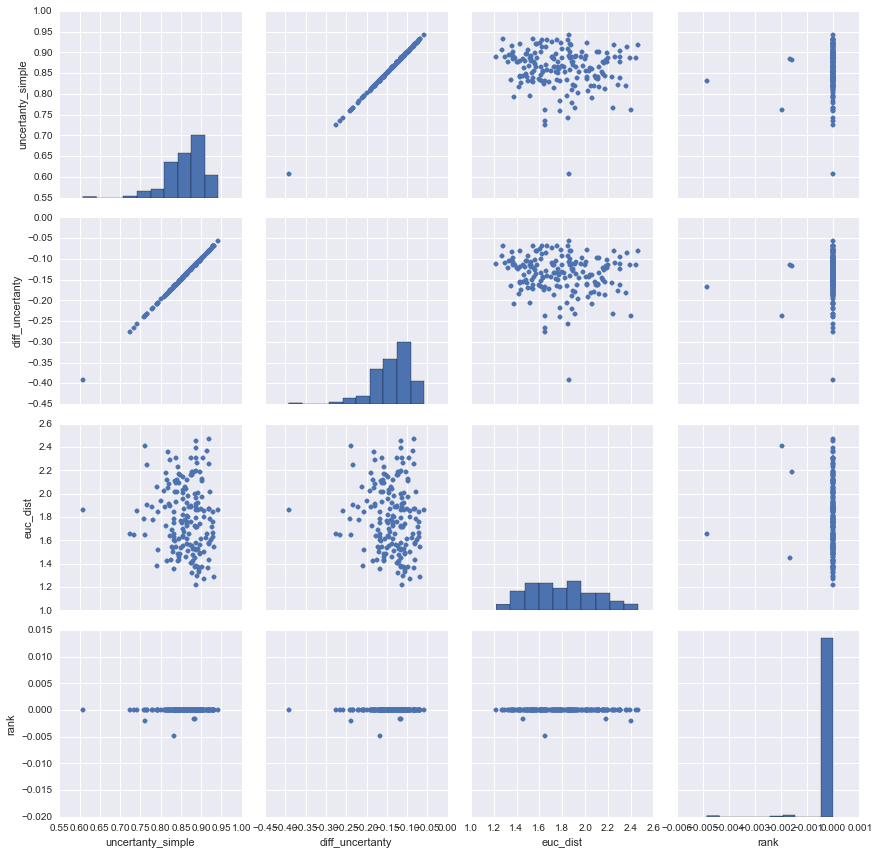

In [57]:
%matplotlib inline
import seaborn as sns
sns.set()

sns.pairplot(active_data)